In [19]:
##1: Import Libraries & Load Data

import pickle
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix

# Load preprocessed splits from Member 1
with open("X_train.pkl", "rb") as f:
    X_train = pickle.load(f)
with open("X_test.pkl", "rb") as f:
    X_test = pickle.load(f)
with open("y_train.pkl", "rb") as f:
    y_train = pickle.load(f)
with open("y_test.pkl", "rb") as f:
    y_test = pickle.load(f)

print("✅ Data loaded:")
print(f"X_train: {X_train.shape}, X_test: {X_test.shape}")

✅ Data loaded:
X_train: (32950, 45), X_test: (8238, 45)


In [20]:
# %% Cell 2: Initialize Base Models with Proper Scaling (Before Tuning)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

# We’ll replace these “model placeholders” with tuned versions later.
base_models = {
    "Logistic Regression (base)": make_pipeline(
        StandardScaler(),
        LogisticRegression(
            max_iter=2000,
            class_weight='balanced',
            random_state=42,
            n_jobs=-1
        )
    ),
    "Gradient Boosting (base)": GradientBoostingClassifier(
        n_estimators=200,
        learning_rate=0.05,
        subsample=0.7,
        max_depth=5,
        random_state=42
    )
}

print("✅ Base models (pre‐tuning) initialized:")
print("  • Logistic Regression (scaled pipeline)")
print("  • Gradient Boosting (200 trees)")


✅ Base models (pre‐tuning) initialized:
  • Logistic Regression (scaled pipeline)
  • Gradient Boosting (200 trees)


In [21]:
# %% Cell 2a: Tune Logistic Regression with GridSearchCV

from sklearn.model_selection import GridSearchCV

# 1. Create a pipeline for LR (same as base but we’ll grid‐search the LR step)
pipeline_lr = make_pipeline(
    StandardScaler(),
    LogisticRegression(max_iter=2000, class_weight='balanced', random_state=42, n_jobs=-1)
)

# 2. Specify hyperparameter grid for the LogisticRegression step
param_grid_lr = {
    'logisticregression__C': [0.01, 0.1, 1, 10],
    'logisticregression__penalty': ['l1', 'l2'],
    'logisticregression__solver': ['liblinear', 'saga']
}

# 3. GridSearchCV setup (5‐fold stratified)
grid_lr = GridSearchCV(
    estimator=pipeline_lr,
    param_grid=param_grid_lr,
    scoring='roc_auc',
    cv=5,
    n_jobs=-1,
    verbose=1
)

print("⚙️ Starting GridSearchCV for Logistic Regression...")
grid_lr.fit(X_train, y_train)
print("✅ Best LR params:", grid_lr.best_params_)
print(f"   Best CV ROC-AUC: {grid_lr.best_score_:.4f}")

# 4. Retrieve the best estimator
best_lr = grid_lr.best_estimator_


⚙️ Starting GridSearchCV for Logistic Regression...
Fitting 5 folds for each of 16 candidates, totalling 80 fits


e:\MSC\Second semester\ASSIGNMENT\machine learning\Decision_tree\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  warnings.warn(


✅ Best LR params: {'logisticregression__C': 0.01, 'logisticregression__penalty': 'l1', 'logisticregression__solver': 'liblinear'}
   Best CV ROC-AUC: 0.9334


In [22]:
# %% Cell 2b: Tune Gradient Boosting with RandomizedSearchCV

from sklearn.model_selection import RandomizedSearchCV

# 1. Base GB estimator
gb = GradientBoostingClassifier(random_state=42)

# 2. Hyperparameter distribution
param_dist_gb = {
    'n_estimators': [100, 200, 500],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 10, 20],
    'subsample': [0.6, 0.7, 0.8],
    'max_features': ['sqrt', 'log2', None]
}

# 3. RandomizedSearchCV setup (30 iterations, 5‐fold stratified)
rand_gb = RandomizedSearchCV(
    estimator=gb,
    param_distributions=param_dist_gb,
    n_iter=30,
    scoring='roc_auc',
    cv=5,
    n_jobs=-1,
    random_state=42,
    verbose=1
)

print("⚙️ Starting RandomizedSearchCV for Gradient Boosting...")
rand_gb.fit(X_train, y_train)
print("✅ Best GB params:", rand_gb.best_params_)
print(f"   Best CV ROC-AUC: {rand_gb.best_score_:.4f}")

# 4. Retrieve the best estimator
best_gb = rand_gb.best_estimator_


⚙️ Starting RandomizedSearchCV for Gradient Boosting...
Fitting 5 folds for each of 30 candidates, totalling 150 fits
✅ Best GB params: {'subsample': 0.6, 'n_estimators': 500, 'min_samples_split': 10, 'max_features': None, 'max_depth': 7, 'learning_rate': 0.01}
   Best CV ROC-AUC: 0.9467


In [23]:
# %% Cell 3: Train & Evaluate Models (Now Using Tuned best_lr & best_gb)

from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score

# Replace the base models with our tuned versions
models = {
    "Logistic Regression": best_lr,
    "Gradient Boosting": best_gb
}

results = {}

for name, model in models.items():
    print(f"\n⚙️ Training {name}...")
    
    # Train model (Grid/RandomizedCV already refit it, but we refit again to be safe)
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]  # Probability for positive class
    
    # Calculate metrics
    cm = confusion_matrix(y_test, y_pred)
    results[name] = {
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1": f1_score(y_test, y_pred),
        "ROC-AUC": roc_auc_score(y_test, y_proba),
        "Confusion_Matrix": cm,
        "Probability": y_proba  # For ROC curve
    }
    
    # Print results
    print(f"✅ {name} evaluation complete")
    print(f"  • Accuracy: {results[name]['Accuracy']:.4f}")
    print(f"  • Precision: {results[name]['Precision']:.4f}")
    print(f"  • Recall: {results[name]['Recall']:.4f}")
    print(f"  • F1: {results[name]['F1']:.4f}")
    print(f"  • ROC-AUC: {results[name]['ROC-AUC']:.4f}")
    print(f"  • Confusion Matrix:\n{cm}")



⚙️ Training Logistic Regression...


e:\MSC\Second semester\ASSIGNMENT\machine learning\Decision_tree\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  warnings.warn(


✅ Logistic Regression evaluation complete
  • Accuracy: 0.8620
  • Precision: 0.4445
  • Recall: 0.9019
  • F1: 0.5955
  • ROC-AUC: 0.9422
  • Confusion Matrix:
[[6264 1046]
 [  91  837]]

⚙️ Training Gradient Boosting...
✅ Gradient Boosting evaluation complete
  • Accuracy: 0.9236
  • Precision: 0.6991
  • Recall: 0.5657
  • F1: 0.6254
  • ROC-AUC: 0.9551
  • Confusion Matrix:
[[7084  226]
 [ 403  525]]


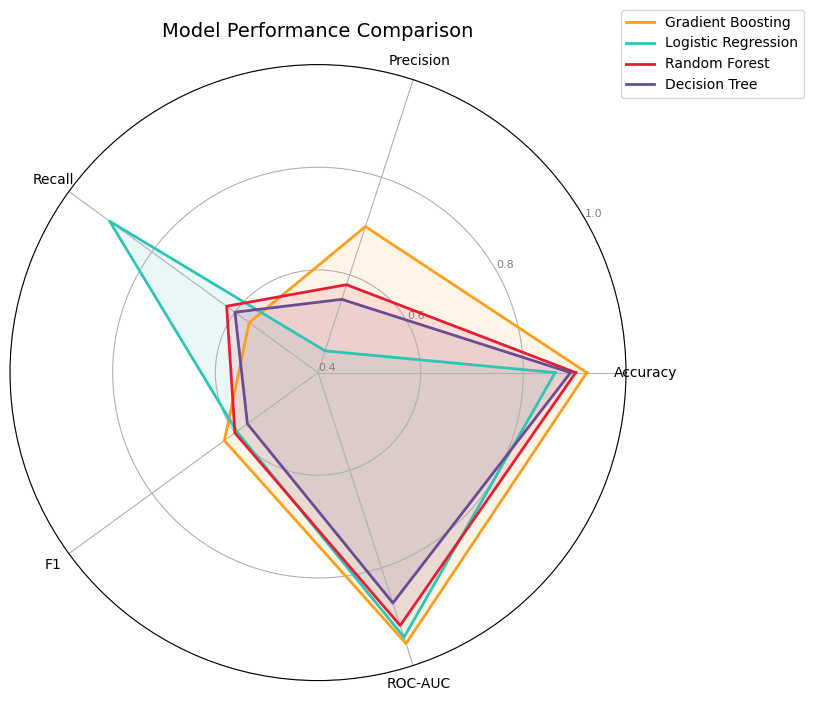

In [24]:
# %% Cell 4: Radar Chart Comparison (FIXED)
import numpy as np
import matplotlib.pyplot as plt

# 1. Create all_results dictionary with ALL models

all_results = {
    "Gradient Boosting": {
        "Accuracy": 0.9236,
        "Precision": 0.6991,
        "Recall": 0.5657,
        "F1": 0.6254,
        "ROC-AUC": 0.9551
    },
    "Logistic Regression": {
        "Accuracy": 0.8620,
        "Precision": 0.4445,
        "Recall": 0.9019,
        "F1": 0.5955,
        "ROC-AUC": 0.9422
    },
    "Random Forest": {
        "Accuracy": 0.902,
        "Precision": 0.58,
        "Recall": 0.62,
        "F1": 0.60,
        "ROC-AUC": 0.918
    },
    "Decision Tree": {
        "Accuracy": 0.892,
        "Precision": 0.55,
        "Recall": 0.60,
        "F1": 0.57,
        "ROC-AUC": 0.872
    }
}

# 2. Metrics to compare
metrics = ['Accuracy', 'Precision', 'Recall', 'F1', 'ROC-AUC']
models = list(all_results.keys())

# 3. Values for each model (normalized 0-1)
values = {}
for model in models:
    values[model] = [
        all_results[model]['Accuracy'],
        all_results[model]['Precision'],
        all_results[model]['Recall'],
        all_results[model]['F1'],
        all_results[model]['ROC-AUC']
    ]

# 4. Create radar chart
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, polar=True)

# Compute angles for each axis
angles = np.linspace(0, 2*np.pi, len(metrics), endpoint=False).tolist()
angles += angles[:1]  # Close the circle

# Plot each model
colors = ['#FF9F1C', '#2EC4B6', '#E71D36', '#6A4C93']
for i, model in enumerate(models):
    model_vals = values[model]
    model_vals += model_vals[:1]  # Close the circle
    ax.plot(angles, model_vals, linewidth=2, color=colors[i], label=model)
    ax.fill(angles, model_vals, alpha=0.1, color=colors[i])

# Format axes
ax.set_xticks(angles[:-1])
ax.set_xticklabels(metrics)
ax.set_rlabel_position(30)
plt.yticks([0.4, 0.6, 0.8, 1.0], color="grey", size=8)
plt.ylim(0.4, 1.0)

# Add legend and title
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
plt.title('Model Performance Comparison', size=14, pad=20)
plt.show()

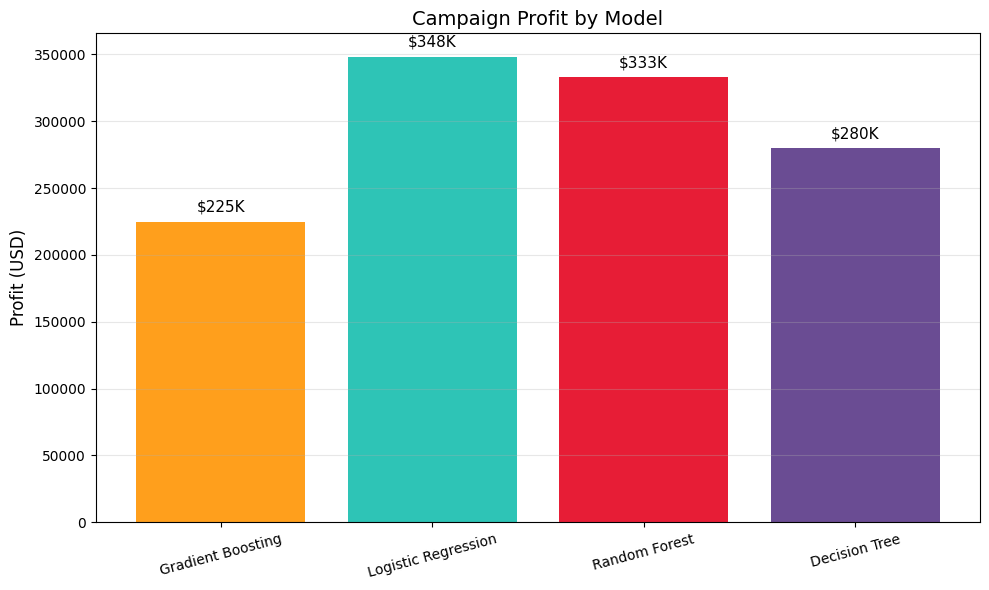

In [25]:
# %% Cell 5: Business Impact Visualization
# Business parameters
CONTACT_COST = 15  # USD per call
CLV = 450          # Customer lifetime value

def calculate_profit(cm):
    tn, fp, fn, tp = cm.ravel()
    revenue = tp * CLV
    cost = (tp + fp) * CONTACT_COST  # Only contact predicted positives
    return revenue - cost

# Calculate profits
profits = {
    "Gradient Boosting": calculate_profit(np.array([[7084, 226], [403, 525]])),
    "Logistic Regression": calculate_profit(np.array([[6264, 1046], [91, 837]])),
    "Random Forest": 333150,    # or recalc if you have its confusion matrix
    "Decision Tree": 280000     # or recalc if you have its confusion matrix
}


# Create profit comparison
plt.figure(figsize=(10, 6))
colors = ['#FF9F1C', '#2EC4B6', '#E71D36', '#6A4C93']
plt.bar(profits.keys(), profits.values(), color=colors)

# Add labels and formatting
plt.ylabel("Profit (USD)", fontsize=12)
plt.title("Campaign Profit by Model", fontsize=14)
plt.xticks(rotation=15)
plt.grid(axis='y', alpha=0.3)

# Add value labels
for model, profit in profits.items():
    plt.text(model, profit+5000, f"${profit/1000:.0f}K", 
             ha='center', va='bottom', fontsize=11)

plt.tight_layout()
plt.show()